# Imports and definitions

In [ ]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import matplotlib.pyplot as plt

# Sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.mixture import BayesianGaussianMixture

import warnings
warnings.filterwarnings("ignore")

from drive.MyDrive.Kaggle.Clustering_072022.src.functions import *

In [ ]:
PATH = 'drive/MyDrive/Kaggle/Clustering_072022/'
data = pd.read_csv(PATH+'src/data_removed.csv', index_col='id')

cat_feats = data.columns[data.dtypes=='int'].tolist()
num_feats = data.columns[data.dtypes=='float'].tolist()

# Data transformation/scaling
- I used just powertransformer originally as just a baseline but it performed quite well so I will continue with just this transformation/scaling until I have extra time to test other variations out.
- The cat columns are responsible for nearly all of the score so I think that is why it excelled.

In [ ]:
pt_df = pd.DataFrame(PowerTransformer().fit_transform(data), columns=data.columns)

# Soft Voting Predictions
- I also capture the predict proba to run some stats on later to find the low confidence rows

In [ ]:
clusters = [0, 1, 2, 3, 4, 5, 6]
preds = pd.DataFrame(np.zeros((pt_df.shape[0], 7)), columns=clusters, dtype='float64')
df = pd.DataFrame(index=data.index)
df['median'] = 0
df['median_arg_max'] = 0
df['predict_proba'] = 0
df['predict_proba_preds'] = 0
train_idx_lists = []
test_idx_lists = []

for idx, seed in tqdm(enumerate(range(188, 190))):

    # bgm = BayesianGaussianMixture(
    #     n_components=7,
    #     covariance_type='full',
    #     max_iter=400,
    #     n_init=3,
    #     random_state=seed
    #     )
    # bgm.fit(pt_df)
    pred_seed = bgm.predict_proba(pt_df)
    preds = bgm.predict(pt_df)
    # You only need to copy the seed array the first round since you add to the copy afterwords
    if idx == 0:
        tmp = pred_seed.copy()
        pred_seed_array = tmp[:,:, np.newaxis]
    else:
        tmp = pred_seed.copy()
        pred_seed_array = np.concatenate((pred_seed_array, tmp[:,:, np.newaxis]), axis=2)
    
    df['prediction'] = np.argmax(pred_seed, axis=1)
    df['prediction_bgm'] = preds
    for n in range(7):
        df[f'predict_proba_{n}'] = pred_seed[:, n]
        df.loc[df.prediction == n, 'predict_proba'] = df[f'predict_proba_{n}']
        df[f'predict_proba_preds{n}'] = pred_seed[:, n]
        df.loc[df.prediction_bgm==n, 'predict_proba_preds'] = df[f'predict_proba_preds{n}']
        df.loc[seed, 'median_arg_max'] = df[df['prediction'] == n]['predict_proba'].median()
        df.loc[seed, 'median'] = df[df['prediction_bgm'] == n]['predict_proba'].median()

        if idx == 0:
            df[f'proba_max_{n}'] = pred_seed[:, n]
            df[f'proba_min_{n}'] = pred_seed[:, n]
            df[f'proba_{n}'] = pred_seed[:, n]
        else:
            df[f'proba_{n}'] += pred_seed[:, n]
            if pred_seed[:, n] > df[f'proba_max_{n}']:
                df[f'proba_max_{n}'] = pred_seed[:, n]
            if df[f'proba_min_{n}'] < pred_seed[:, n]:
                df[f'proba_min_{n}'] = pred_seed[:, n]

    # pred_keys = df[f'pred_max_{seed}'].value_counts().index.tolist()
    # pred_dict = dict(zip(pred_keys, clusters))
    # df[f'pred_{seed}'] = df[f'pred_max_{seed}'].map(pred_dict)

    pred_new = pd.DataFrame(pred_seed).rename(columns=pred_dict)
    pred_new
    break
    pred_new = pred_new.reindex(sorted(pred_new.columns), axis=1)
    preds += pred_new
    
# predictions = np.argmax(np.array(preds), axis=1)
# sub = pd.read_csv(PATH+'submissions/sample_submission.csv', index_col='Id')
# sub['Predicted'] = predictions
# sub.to_csv(PATH+'submissions/soft_vote/BGM_7_RSPT_5700seed_bestcolumns.csv', index='Id')

0it [00:01, ?it/s]


In [ ]:
pred_new

,3,1,4,0,2,5,6
0,0.977063,3.372370e-03,5.126563e-07,0.000436,0.002553,0.003310,0.013265
1,0.000307,9.208537e-06,1.436074e-02,0.003376,0.028571,0.017490,0.935887
2,0.812458,1.856217e-01,1.035253e-08,0.001460,0.000018,0.000100,0.000342
3,0.000017,9.291166e-02,8.538370e-01,0.027531,0.011342,0.000049,0.014313
4,0.000005,8.668987e-06,9.293586e-07,0.979425,0.000003,0.000174,0.020384
...,...,...,...,...,...,...,...
97995,0.014191,1.802808e-01,1.227264e-03,0.093084,0.224022,0.002845,0.484350
97996,0.000704,1.797313e-05,1.242232e-08,0.416332,0.540807,0.008702,0.033437
97997,0.006243,9.503994e-01,9.159796e-05,0.033670,0.000311,0.001038,0.008247
97998,0.000541,1.377989e-01,4.060971e-02,0.000429,0.037992,0.698466,0.084164


# Calculating Stats from Probabilities
- I captured more than whats needed, just to make sure I did not have to run the soft voting again

In [ ]:
arr = pred_seed_array.copy()
pred_array_df = pd.DataFrame(columns=['mean_diff', 'max_diff', 'min_diff', 'mean_stds', 'max_stds', 'min_stds'])
for idx, x in tqdm(enumerate(arr)):
    value_dict = {}
    arr_sorted = np.sort(x, axis=0)
    differences = arr_sorted[6, :] - arr_sorted[5, :]
    value_dict['mean_diff'], value_dict['max_diff'], value_dict['min_diff'] = differences.mean(), differences.max(), differences.min()
    stds = np.std(x, axis=0)
    value_dict['mean_stds'], value_dict['max_stds'], value_dict['min_stds'] = stds.mean(), stds.max(), stds.min()
    temp = pd.DataFrame([value_dict])
    pred_array_df = pd.concat([pred_array_df, temp], axis=0, ignore_index=True)

98000it [02:19, 704.82it/s]


In [ ]:
pred_array_df.describe()

,mean_diff,max_diff,min_diff,mean_stds,max_stds,min_stds
count,98000.000000,98000.000000,9.800000e+04,98000.000000,98000.000000,98000.000000
mean,0.708141,0.810289,5.981400e-01,0.291592,0.309717,0.273080
std,0.299954,0.233741,3.514825e-01,0.057572,0.047230,0.064798
min,0.002979,0.020454,6.052722e-08,0.079861,0.100758,0.071913
25%,0.482413,0.696992,2.555677e-01,0.245615,0.282441,0.221525
50%,0.831017,0.921368,6.897448e-01,0.312288,0.331518,0.283509
75%,0.970197,0.988662,9.408716e-01,0.343143,0.347237,0.336637
max,1.000000,1.000000,1.000000e+00,0.349927,0.349927,0.349927


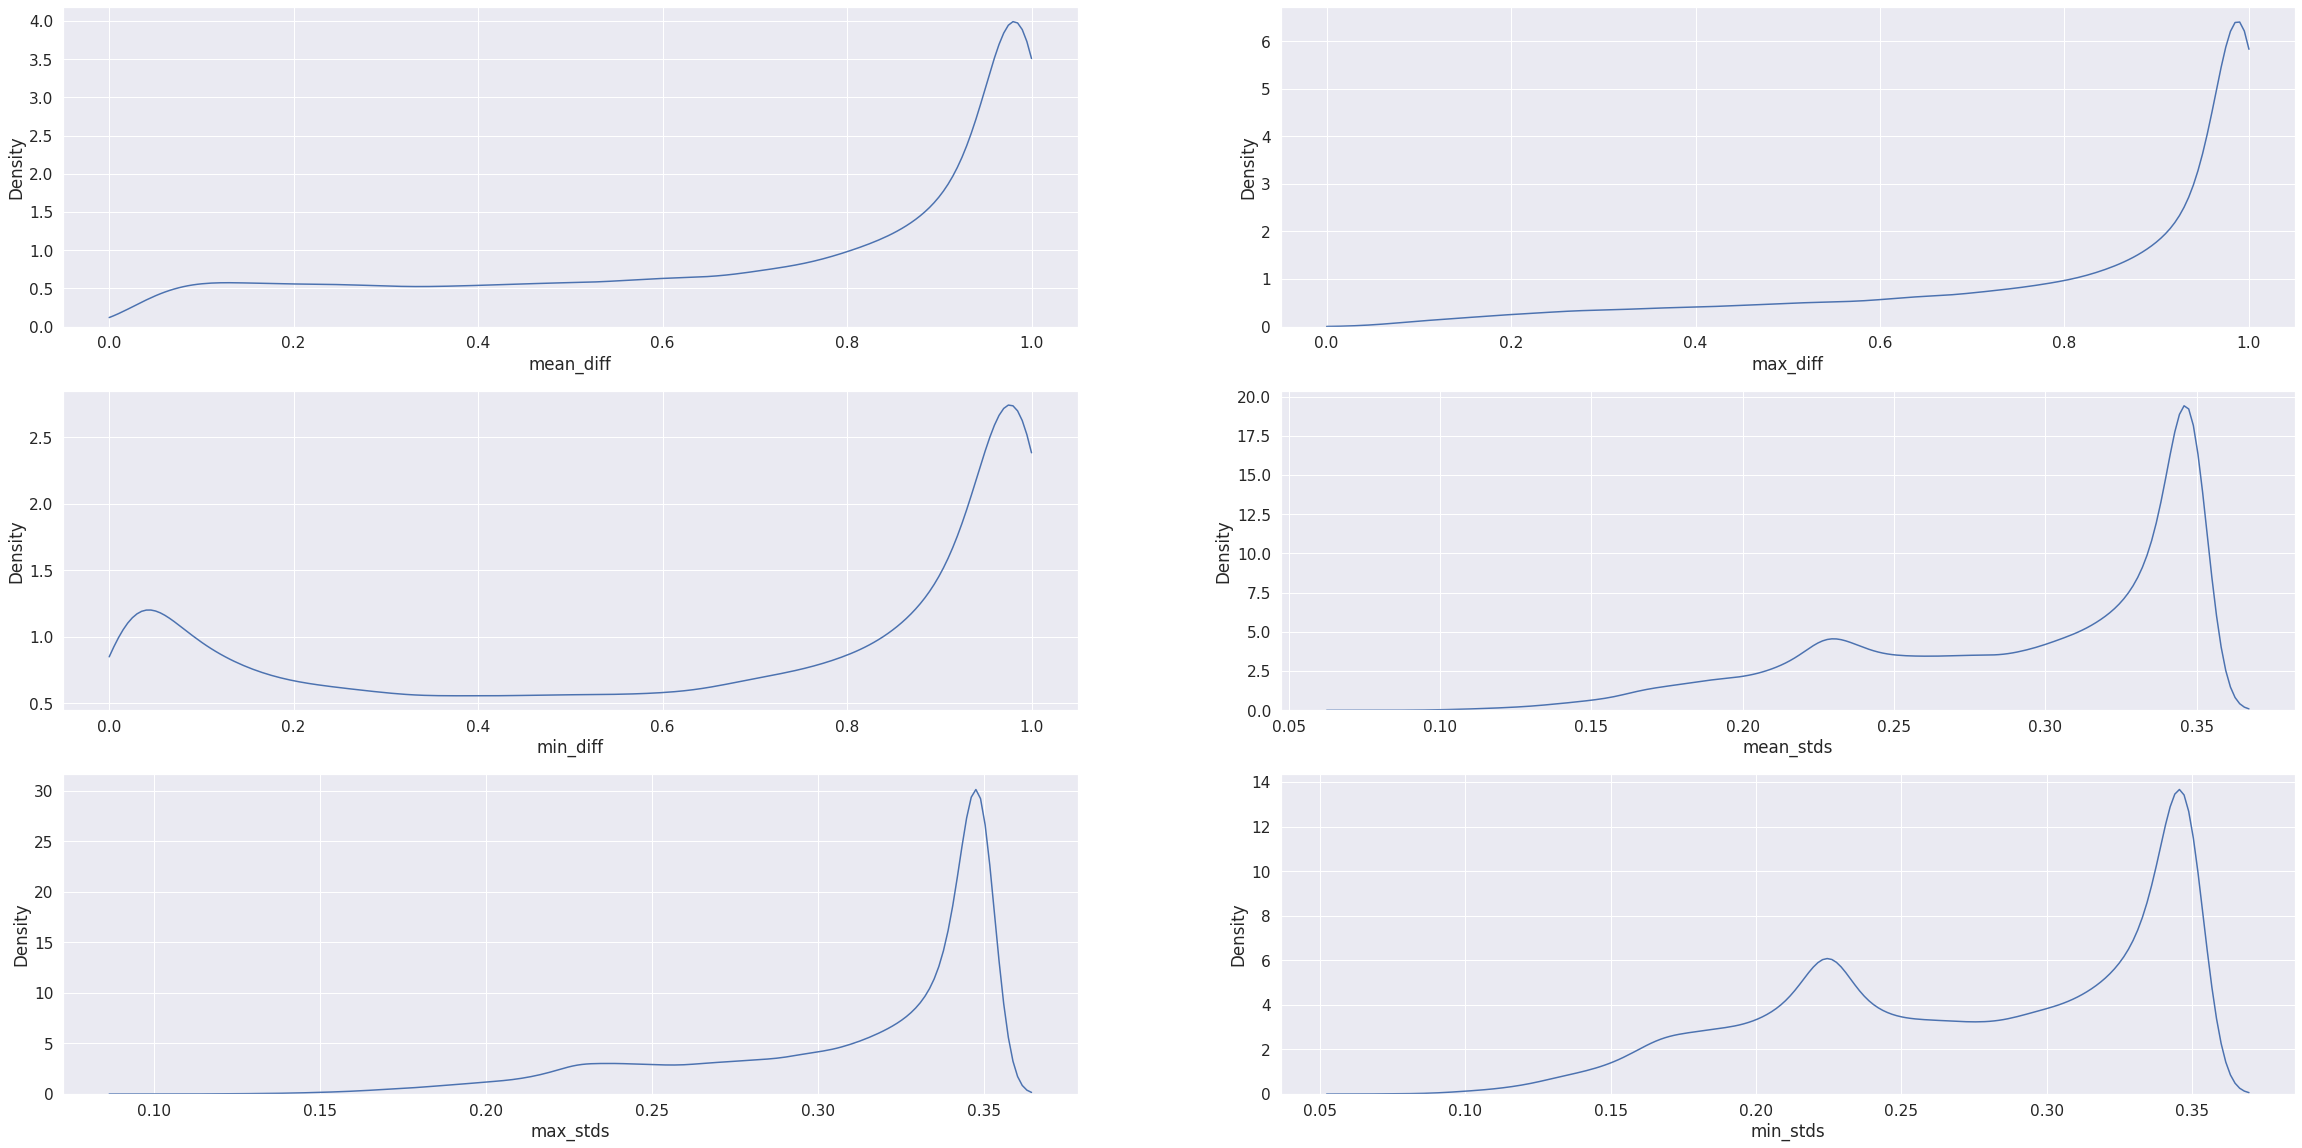

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(40, 20))
axes = axs.ravel()
for ax, feature in zip(axes, pred_array_df.columns):
    sns.kdeplot(data=pred_array_df, x=feature, ax=ax, clip=[0, 1])

In [ ]:
low_stds = pred_array_df[pred_array_df['mean_stds'] > pred_array_df['mean_stds'].quantile(q=0.5)]
low_stds.sort_values('max_diff', ascending=False)

,mean_diff,max_diff,min_diff,mean_stds,max_stds,min_stds,predictions
1346,1.000000,1.000000,1.000000,0.349927,0.349927,0.349927,5
69147,1.000000,1.000000,1.000000,0.349927,0.349927,0.349927,5
18097,1.000000,1.000000,1.000000,0.349927,0.349927,0.349927,5
4698,1.000000,1.000000,1.000000,0.349927,0.349927,0.349927,5
19816,1.000000,1.000000,1.000000,0.349927,0.349927,0.349927,5
...,...,...,...,...,...,...,...
89971,0.811214,0.815164,0.683518,0.312528,0.313280,0.289727,0
82163,0.812278,0.815047,0.771747,0.313019,0.313559,0.305488,4
89560,0.806818,0.814673,0.704478,0.312297,0.313709,0.294041,0
43782,0.809567,0.813382,0.041223,0.312700,0.313329,0.195342,3


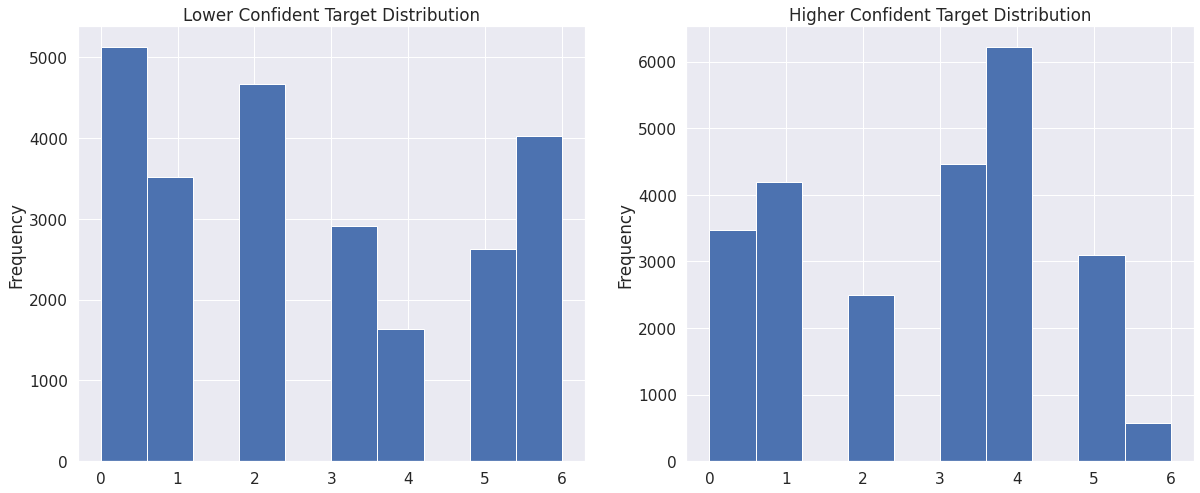

In [ ]:
pred_array_df['predictions'] = sub['Predicted']
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
pred_array_df[pred_array_df['mean_stds'] < pred_array_df['mean_stds'].quantile(0.25)]['predictions'].plot(kind='hist', title='Lower Confident Target Distribution', ax=axs[0])
pred_array_df[pred_array_df['mean_stds'] > pred_array_df['mean_stds'].quantile(0.75)]['predictions'].plot(kind='hist', title='Higher Confident Target Distribution', ax=axs[1])

# Indexing Rows
- My reasoning for max stds and diff: 
- Max stds is the max standard deviation of the predicted cluster probalities out of all 200 seeds. A lower STD signifies a lower confidence of predicted cluster because the predicted probabilities are closer together - there wasn't a 'clear' winner. 
- Max diff is the difference in probability between the first and second choice. A lower max diff tells us there was a smaller margin between first and second choice - the algo had a harder time choosing a winner.
- In each case I chose maximum over mean because it guarantees there was no value larger than it. It could have a small mean of these metrics and still higher confidence predictions.
- I will be using this information to build a classifier: training data will use the top 25 quantile of minimum difference and std and test data, the lower 25 quantile. Depending on the classifier I may alter the quantile for computational limits.

In [ ]:
low_stds = pred_array_df[pred_array_df['max_stds'] < pred_array_df['max_stds'].quantile(q=0.25)].index
low_diff = pred_array_df[pred_array_df['max_diff'] < pred_array_df['max_diff'].quantile(q=0.25)].index
low_confidence = set(low_stds).intersection(set(low_diff))
print(len(low_confidence))

high_stds = pred_array_df[pred_array_df['min_stds'] > pred_array_df['min_stds'].quantile(q=0.75)].index
high_diff = pred_array_df[pred_array_df['min_diff'] > pred_array_df['min_diff'].quantile(q=0.75)].index
high_confidence = set(high_stds).intersection(set(high_diff))
print(len(high_confidence))

23270
24028


In [ ]:
with open('drive/MyDrive/Kaggle/Clustering_072022/src/low_confidence_rows.pkl', 'wb') as f:
    pickle.dump(low_confidence_rows, f)

In [ ]:
rows = pickle.load(open('drive/MyDrive/Kaggle/Clustering_072022/src/low_confidence_rows.pkl', 'rb'))
rows

{32790,
 24,
 65581,
 47,
 32817,
 65591,
 32829,
 65605,
 32843,
 65623,
 65631,
 101,
 65637,
 32873,
 65641,
 115,
 65661,
 65667,
 137,
 32909,
 151,
 65692,
 65695,
 65707,
 184,
 194,
 199,
 203,
 32981,
 220,
 32991,
 33002,
 65802,
 33042,
 33056,
 33069,
 65840,
 33076,
 311,
 65850,
 65851,
 324,
 33092,
 33093,
 65876,
 65877,
 33121,
 368,
 65904,
 33145,
 65915,
 33149,
 382,
 384,
 33153,
 33154,
 389,
 33159,
 33162,
 395,
 400,
 33168,
 33178,
 65946,
 65948,
 65969,
 65983,
 448,
 65988,
 33227,
 33234,
 470,
 33251,
 66024,
 33270,
 66038,
 33284,
 520,
 33289,
 66067,
 554,
 66091,
 557,
 33328,
 33338,
 33342,
 33347,
 66123,
 66125,
 592,
 66134,
 610,
 33380,
 615,
 625,
 627,
 66165,
 634,
 33408,
 66180,
 33419,
 653,
 654,
 66193,
 658,
 33435,
 670,
 66207,
 66210,
 33456,
 33463,
 66237,
 33471,
 66241,
 708,
 712,
 33483,
 730,
 744,
 66283,
 66286,
 33519,
 66288,
 66294,
 759,
 764,
 33532,
 66306,
 66316,
 782,
 66320,
 33554,
 66328,
 66330,
 797,
 33567